## Install hopsworks

## Imports

In [1]:
%pip uninstall hopsworks hsfs hsml -y

%pip install hopsworks

Found existing installation: hopsworks 4.1.4
Uninstalling hopsworks-4.1.4:
  Successfully uninstalled hopsworks-4.1.4
Note: you may need to restart the kernel to use updated packages.
  Using cached hopsworks-4.1.4-py3-none-any.whl.metadata (11 kB)
Using cached hopsworks-4.1.4-py3-none-any.whl (640 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import requests

from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

#Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score

import hopsworks
import json
import warnings
warnings.filterwarnings("ignore")

/Users/martinbravodiaz/miniconda3/envs/imdb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data from Hopsworks

In [3]:
project = hopsworks.login(project="dbillLab1")
fs = project.get_feature_store()

movie_fg = fs.get_feature_group(
    name='tmdb_movies',
    version=1,
)

genres_fg= fs.get_feature_group(
    name='tmdb_movie_genres',
    version=1,
)

2025-01-08 03:45:51,483 INFO: Initializing external client
2025-01-08 03:45:51,484 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 03:45:53,119 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169559


In [4]:
movie_df=movie_fg.read()
genres_df=genres_fg.read()

selected_columns = ['title','release_year', 'runtime', 'budget',
                                     'original_language', 'imdb_rating', 'production_companies','producers', 'cast',
                                     'production_countries', 'imdb_votes', 'id']
movie_df = movie_df[selected_columns]

merged_df = pd.merge(movie_df, genres_df, on='id', how='inner')

merged_df.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.53s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.85s) 


,title,release_year,runtime,budget,original_language,imdb_rating,production_companies,producers,cast,production_countries,...,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
0,Moscow Heat,2004,89.0,0.0,en,2.5,"ITN Distribution, Czar Pictures","Alexander Nevsky, Alexander Izotov","Joanna Pacula, Evgeniy Berezovskiy, Jeff Celen...",Russia,...,0,0,0,0,0,0,0,1,0,0
1,A Killing Affair,1977,100.0,0.0,en,6.1,"Columbia Pictures Television, David Gerber Pro...","James H. Brown, David Gerber","Todd Bridges, Sari Price, Dean Stockwell, Robe...",United States of America,...,0,0,0,0,0,0,1,0,0,0
2,Top Secret,1952,93.0,0.0,en,6.3,"Mario Zampi Productions, Associated British Pi...",Mario Zampi,"Reed De Rouen, Henry Hewitt, Michael Medwin, W...",United Kingdom,...,0,0,0,0,0,0,0,0,0,0
3,How to Change the World,2014,110.0,0.0,en,7.5,"BFI, Met Film Production, Daniel Film, Insight...","Bous De Jong, Stewart Le Marechal, Lizzie Fran...","Robert Hunter, Bobbi Hunter, David Garrick, Pa...","United Kingdom, Canada",...,1,0,0,0,0,0,0,0,0,0
4,The Man Who Could Work Miracles,1936,82.0,0.0,en,6.9,London Films Productions,Alexander Korda,"George Zucco, Ernest Thesiger, Torin Thatcher,...",United Kingdom,...,0,0,0,0,0,0,0,0,0,0


In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Label encoding categorical features
df1=merged_df.copy()
df1['first_producer'] = df1['producers'].str.split(',').str[0]
df1['first_actor']=df1["cast"].str.split(',').str[0]
df1['first_company'] = df1['production_companies'].str.split(',').str[0]

threshold = 0.001  # Minimum frequency threshold (1%)
producer_counts = df1['first_company'].value_counts(normalize=True)
df1 = df1.dropna(subset=['first_company'])
df1['first_company'] = df1['first_company'].apply(lambda x: x if producer_counts[x] > threshold else 'Other')

df1['first_producer'] = label_encoder.fit_transform(df1['first_producer'])
df1['first_actor'] = label_encoder.fit_transform(df1['first_actor'])
df1['first_company'] = label_encoder.fit_transform(df1['first_company'])
df1['original_language'] = label_encoder.fit_transform(df1['original_language'])

print(len(df1["first_producer"].unique()))
print(len(df1["first_actor"].unique()))
print(len(df1["first_company"].unique()))


print(df1["first_company"].unique())

df1.head()

13945
21656
68
[36 26  7 66 29 38 40 62 58 25  0 10 61 50 52 30 44 14  2 18 22 34 32 57
 42 28 37 49 46 19  6 56 51 65 33  3 60 13 21 35 39 17 64 24 54  9 48 45
 27 16 12 43 11 53  5 15 31 41  4 47  1 59  8 67 63 55 20 23]


,title,release_year,runtime,budget,original_language,imdb_rating,production_companies,producers,cast,production_countries,...,mystery,romance,science_fiction,tv_movie,thriller,war,western,first_producer,first_actor,first_company
0,Moscow Heat,2004,89.0,0.0,14,2.5,"ITN Distribution, Czar Pictures","Alexander Nevsky, Alexander Izotov","Joanna Pacula, Evgeniy Berezovskiy, Jeff Celen...",Russia,...,0,0,0,0,1,0,0,390,9656,36
1,A Killing Affair,1977,100.0,0.0,14,6.1,"Columbia Pictures Television, David Gerber Pro...","James H. Brown, David Gerber","Todd Bridges, Sari Price, Dean Stockwell, Robe...",United States of America,...,0,0,0,1,0,0,0,5497,20120,36
2,Top Secret,1952,93.0,0.0,14,6.3,"Mario Zampi Productions, Associated British Pi...",Mario Zampi,"Reed De Rouen, Henry Hewitt, Michael Medwin, W...",United Kingdom,...,0,0,0,0,0,0,0,8389,16819,36
3,How to Change the World,2014,110.0,0.0,14,7.5,"BFI, Met Film Production, Daniel Film, Insight...","Bous De Jong, Stewart Le Marechal, Lizzie Fran...","Robert Hunter, Bobbi Hunter, David Garrick, Pa...","United Kingdom, Canada",...,0,0,0,0,0,0,0,1546,17360,36
4,The Man Who Could Work Miracles,1936,82.0,0.0,14,6.9,London Films Productions,Alexander Korda,"George Zucco, Ernest Thesiger, Torin Thatcher,...",United Kingdom,...,0,0,0,0,0,0,0,388,6946,26


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25708 entries, 0 to 25707
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype                  
---  ------                --------------  -----                  
 0   title                 25708 non-null  object                 
 1   release_year          25708 non-null  int32                  
 2   runtime               25708 non-null  float64                
 3   budget                25708 non-null  float64                
 4   original_language     25708 non-null  int64                  
 5   imdb_rating           25708 non-null  float64                
 6   production_companies  25708 non-null  object                 
 7   producers             25708 non-null  object                 
 8   cast                  25708 non-null  object                 
 9   production_countries  25708 non-null  object                 
 10  imdb_votes            25708 non-null  float64                
 11  id             

In [7]:
from sklearn.model_selection import train_test_split
labels=df1["imdb_rating"]
features=df1.drop(["imdb_rating", "title", "id", "timestamp", "production_countries",
                   "producers", "cast", "production_companies"
                   ], axis=1)
# Splitting the DataFrame into features (X) and target (y)
X = features  # Features
y = labels  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print(type(y_test))

<class 'pandas.core.series.Series'>


In [9]:
X_train.columns

Index(['release_year', 'runtime', 'budget', 'original_language', 'imdb_votes',
       'action', 'adventure', 'animation', 'comedy', 'crime', 'documentary',
       'drama', 'family', 'fantasy', 'history', 'horror', 'music', 'mystery',
       'romance', 'science_fiction', 'tv_movie', 'thriller', 'war', 'western',
       'first_producer', 'first_actor', 'first_company'],
      dtype='object')

# Training models
XGBoost, RandomForest, Linear Regression, SVR, DecisionTree

In [10]:
from xgboost import XGBRegressor

xgb_model= XGBRegressor()
rf_model= RandomForestRegressor(random_state=48)
lr_model= LinearRegression()
svr_model= SVR()
dt_model= DecisionTreeRegressor(random_state=48)

models={
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Linear Regression": lr_model,
    "SVR": svr_model,
    "Decision Tree": dt_model
}

model_scores_MSE={
    "XGBoost": 0,
    "Random Forest": 0,
    "Linear Regression": 0,
    "SVR": 0,
    "Decision Tree": 0
}

model_scores_r2={
    "XGBoost": 0,
    "Random Forest": 0,
    "Linear Regression": 0,
    "SVR": 0,
    "Decision Tree": 0
}

## With categorical features
Removed production countries as they could have several values and majority had the U.S

In [11]:
#with_cat=['id', 'title','timestamp', 'production_countries']

#train_features= X_train.drop(with_cat, axis=1)
#test_features = X_test.drop(with_cat, axis=1)

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name)
    y_pred= model.predict(X_test)
    mse= mean_squared_error(y_test, y_pred)
    print("MSE:", mse)
    r2 = r2_score(y_test, y_pred)
    print("R squared:", r2)
    print('_________')
    models[name]= model
    model_scores_MSE[name]= mse
    model_scores_r2[name]= r2

XGBoost
MSE: 0.5119341223566739
R squared: 0.6058622006273977
_________
Random Forest
MSE: 0.5444033113574486
R squared: 0.5808641898652585
_________
Linear Regression
MSE: 0.8143649429010041
R squared: 0.373020878148127
_________
SVR
MSE: 1.2720306743319385
R squared: 0.0206642831158379
_________
Decision Tree
MSE: 1.1221197977440684
R squared: 0.13608058458908645
_________


In [12]:

xgb_model= XGBRegressor()
rf_model= RandomForestRegressor(random_state=48)
lr_model= LinearRegression()
svr_model= SVR()
dt_model= DecisionTreeRegressor(random_state=48)

models={
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Linear Regression": lr_model,
    "SVR": svr_model,
    "Decision Tree": dt_model
}

model_scores_MSE={
    "XGBoost": 0,
    "Random Forest": 0,
    "Linear Regression": 0,
    "SVR": 0,
    "Decision Tree": 0
}

model_scores_r2={
    "XGBoost": 0,
    "Random Forest": 0,
    "Linear Regression": 0,
    "SVR": 0,
    "Decision Tree": 0
}
#without genres
all_genres=['action', 'adventure', 'animation', 'crime', 'documentary', 'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance', 'science_fiction', 'tv_movie', 'thriller', 'war', 'western']

train_features= X_train.drop(all_genres, axis=1)
test_features = X_test.drop(all_genres, axis=1)

for name, model in models.items():
    model.fit(train_features, y_train)
    print(name)
    y_pred= model.predict(test_features)
    mse= mean_squared_error(y_test, y_pred)
    print("MSE:", mse)
    r2 = r2_score(y_test, y_pred)
    print("R squared:", r2)
    print('_________')
    models[name]= model
    model_scores_MSE[name]= mse
    model_scores_r2[name]= r2

XGBoost
MSE: 0.6801411620063502
R squared: 0.47635969327096617
_________
Random Forest
MSE: 0.6908753488914819
R squared: 0.468095448689097
_________
Linear Regression
MSE: 0.9652113319117076
R squared: 0.2568843261748258
_________
SVR
MSE: 1.271880805162954
R squared: 0.020779667306650262
_________
Decision Tree
MSE: 1.337485414235706
R squared: -0.029729285153094365
_________


## Without categorical features
Removed original language as well since half of the dataset had "en" (english). Removing this feature led to a lower MSE.

In [13]:
drop_list=['original_language']

print("Dropped:", drop_list, "\n")
train_features= X_train.drop(drop_list, axis=1)
test_features = X_test.drop(drop_list, axis=1)

for name, model in models.items():
    model.fit(train_features, y_train)
    print(name)
    y_pred= model.predict(test_features)
    mse= mean_squared_error(y_test, y_pred)
    print("MSE:", mse)
    r2 = r2_score(y_test, y_pred)
    print("R squared:", r2)
    print('_________')
    models[name]= model
    model_scores_MSE[name]= mse
    model_scores_r2[name]= r2

Dropped: ['original_language'] 

XGBoost
MSE: 0.5558981401170888
R squared: 0.5720143275223593
_________
Random Forest
MSE: 0.5807764527421236
R squared: 0.5528605283089065
_________
Linear Regression
MSE: 0.8282829710200947
R squared: 0.3623053959505125
_________
SVR
MSE: 1.272045661923135
R squared: 0.020652744177614868
_________
Decision Tree
MSE: 1.1960073901205759
R squared: 0.07919456783725398
_________


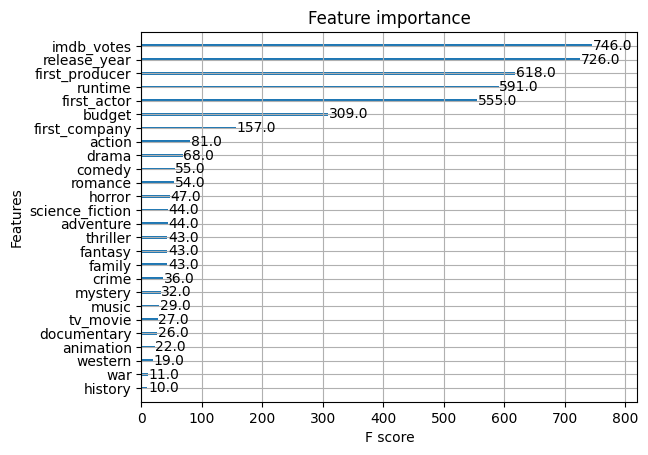

In [14]:
from xgboost import plot_importance

plot_importance(xgb_model)
plt.show()

In [15]:
name="XGBoost"
model = models[name]
r2 = model_scores_r2[name]
mse = model_scores_MSE[name]

In [16]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [17]:
res_dict = {
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [18]:
mr = project.get_model_registry()

model_dir="model"
model.save_model(model_dir + "/model.json")

# Creating a Python model in the model registry named 'imdb_rating_model'

movie_rating_pred_model = mr.python.create_model(
    name="movie_rating_model",
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Movie Rating (1 to 10) predictor",
)

# Saving the model artifacts to the model registry
movie_rating_pred_model.save(model_dir)

Uploading: 100.000%|██████████| 506757/506757 elapsed<00:02 remaining<00:00  1.15it/s]
Uploading: 0.000%|          | 0/0 elapsed<00:00 remaining<?/6 [00:03<00:04,  1.15it/s]
Uploading: 100.000%|██████████| 173476467/173476467 elapsed<00:41 remaining<00:00it/s]
Uploading: 100.000%|██████████| 152/152 elapsed<00:01 remaining<00:00<01:47, 26.84s/it]
Uploading: 100.000%|██████████| 2067/2067 elapsed<00:02 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:56<00:00,  9.36s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1169559/models/movie_rating_model/2


Model(name: 'movie_rating_model', version: 2)